In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
% matplotlib inline 
from astropy import table
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord

Für Tex zur Definition mit RGBA:


(46, 107, 142, 255)

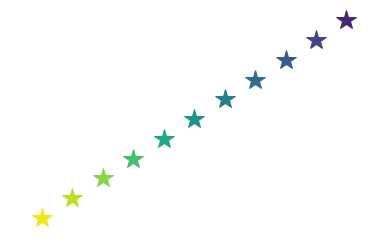

In [2]:
cmap = plt.cm.get_cmap('viridis')
viridis10 = cmap(0.1)
viridis9 = cmap(0.2)
viridis8 = cmap(0.28)
viridis7 = cmap(0.35)
viridis6 = cmap(0.42)
viridis5 = cmap(0.5)
viridis4 = cmap(0.6)
viridis3= cmap(0.7)
viridis2 = cmap(0.82)
viridis1 = cmap(0.9)
viridis0 = cmap(0.98)

plt.plot(0,0,'*',ms=20,color=viridis0)
plt.plot(1,1,'*',ms=20,color=viridis1)
plt.plot(2,2,'*',ms=20,color=viridis2)
plt.plot(3,3,'*',ms=20,color=viridis3)
plt.plot(4,4,'*',ms=20,color=viridis4)
plt.plot(5,5,'*',ms=20,color=viridis5)
plt.plot(6,6,'*',ms=20,color=viridis6)
plt.plot(7,7,'*',ms=20,color=viridis7)
plt.plot(8,8,'*',ms=20,color=viridis8)
plt.plot(9,9,'*',ms=20,color=viridis9)
plt.plot(10,10,'*',ms=20,color=viridis10)

plt.axis('off')
plt.savefig('Results_pdf/Colors.pdf')

print('Für Tex zur Definition mit RGBA:')
cmap(0.35,bytes=True)

# 1. How do read and plot hdf5 files from simulation 

### a.) Read hdf5 files:
     - simulated cube (3x Num_slices) with steady source and background 
     - simulated transient without steady source and background
     - denoised results from wavelet denoising 
     - alert table which lists all detected transients 
! Each file with N_transient entries 

In [3]:
## Simulated cube 
cube = Table.read('/home/jana/Schreibtisch/Projekt_Master/cta_transient_search/build/n2_s60_trandom_cube.hdf5', path='data')
Cube = cube['cube'].max(axis=2).max(axis=2)

## Simulated transient (=cube without background) 
trans = Table.read('/home/jana/Schreibtisch/Projekt_Master/cta_transient_search/build/n2_s60_trandom_trans.hdf5', path='data')
pos = trans['position']
##denoised cube 
den = Table.read('/home/jana/Schreibtisch/Projekt_Master/cta_transient_search/build/n2_s60_trandom_denoised.hdf5', path='data')
trans_factor = den['cube_smoothed'].max(axis=2).max(axis=2)

## Alert Table 
alert = Table.read('/home/jana/Schreibtisch/Projekt_Master/cta_transient_search/build/n2_s60_trandom_thr5_alert.hdf5', path='data')
transient =alert[0]
ts = transient['trigger_index'] 


In [97]:
cube = cube['cube']
cube[0].shape[0]

60

### b.) Plot trigger criterion / Flux 

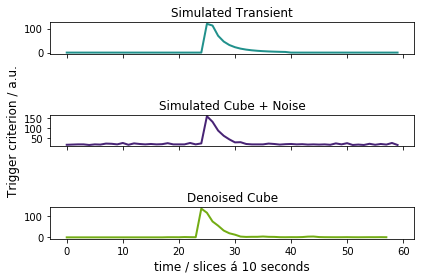

In [7]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True)
ax2.plot(Cube[0],color=viridis10, lw=2)
ax2.set_title('Simulated Cube + Noise')

ax1.plot(trans['timeseries'][0]/65,color=viridis5,lw=2)
ax1.set_title('Simulated Transient')

ax3.plot(trans_factor[0],color='#73ac14',lw=2)
ax3.set_title('Denoised Cube')

ax3.set_xlabel('time / slices á 10 seconds',size='large')
ax2.set_ylabel('Trigger criterion / a.u.',size='large')

fig.tight_layout()
#plt.savefig('Results_jpeg/Signal.jpeg',bbox_inches='tight')
plt.savefig('Results_pdf/Signal.pdf',bbox_inches='tight')

### c.) Read important settings 

In [87]:
'''
Info about transient 
'''
trans['timeseries'][9]       # one entry per slice, producing a kind of lightcurve
trans['cu_flare'][9]         # strength of the transient in units of crab 
trans['template'][9]         # index of the used template / form: 0,1 = Gaussian, 2=exponential
trans['position'][9]         # ra, dec position of the simulated transient (= TRUTH for direction reconstruction)
trans['start_flare'][9]      # Start of the transient  (=TRUTH for Start Slice)
trans['end_flare'][9]        # Arbitrary end of the transient 
trans.meta['n_transient']    # Number of simulated transients 
trans.meta['num_slices']     # Number slices for one whole transient simulation
trans.meta['template']       # Transient template filename, if set to a fixed template
trans.meta['time_per_slice'] # Time per slice 
trans.meta['bins']           # Bins for the camera image


'''
Info about cube with transient and a steady source
'''
cube['cube'][9]                         # 80x80 matrix per time slice 
cube['cube'].max(axis=2).max(axis=2)    # Maximum value per time slice = kind of a lightcurve 
cube['template'][9]                     # index of the used template / form: 0,1 = Gaussian, 2=exponential
cube['num_flare_slices'][9]             # Value of the Slices of transient: Slices = 3*Flare_slices 
cube.meta['fov']                        # FoV of CTA telescopes in array configuration 
cube.meta['steady_source']              # Name of the used steady source 

'''
Info about the denoised cube 
'''
den['cube_smoothed']               # As listed above Num_slices * 80x80 matrices 
den.meta['n_bg_slices']            # Number of slices to start at in background subtraction 
den.meta['gap']                    # Number of slices to jump over in background subtraction  

'''
Info about the alert table
'''
alert['trigger_index'][9]         # List of booleans if trigger threshold was reached in this slice
alert['found_trigger'][9]         # Number of TRUE-Values in trigger_index = Number of alerts
alert['trans_factor_diff'][9]     # List of Trans Factor - moving average 
alert.meta['threshold']

6

## d.) Plot imshows

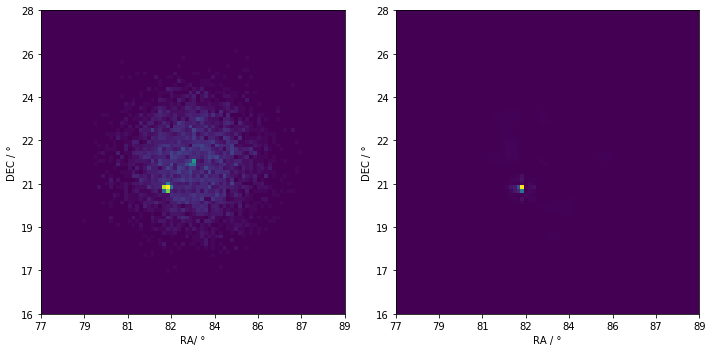

In [11]:
Start = cube
End = den
pos = trans['position'][0]
Unden = Start['cube'][0]
Den = End['cube_smoothed'][0]

fig, (ax1,ax2) = plt.subplots(1,2, sharex=True,figsize=(10,5))

vmax = Unden.max()
ax1.pcolormesh(Unden[26], cmap='viridis',vmin=0, vmax=vmax/3)
ax2.pcolormesh(Den[26], cmap='viridis',vmin=0, vmax=vmax/3)

'''
Ticks on axis
'''
import astropy.units as u
from astropy.coordinates import SkyCoord
crab_coord = SkyCoord('05 34 31.97 +22 00 52.1', unit=(u.hourangle, u.deg))
fov = cube.meta['fov']  

RA_min = crab_coord.ra.deg - fov / 2
RA_max = crab_coord.ra.deg + fov / 2
DEC_min = crab_coord.dec.deg - fov / 2
DEC_max = crab_coord.dec.deg + fov / 2
plt.setp((ax1,ax2), xticks=np.linspace(0,80,8), xticklabels=np.linspace(RA_min,RA_max,8,dtype=int),
        yticks = np.linspace(0,80,8),yticklabels=np.linspace(DEC_min,DEC_max,8,dtype=int))

ax1.set_xlabel('RA/ °')
ax2.set_xlabel('RA / °')
ax1.set_ylabel('DEC / °')
ax2.set_ylabel('DEC / °')
fig.tight_layout()
#plt.savefig('Results_jpeg/Detection.jpeg')
plt.savefig('Results_pdf/Detection.pdf')

In [24]:
def plot_imshow(name,Output,loc1,loc2):
    cube = Table.read('/home/jana/Schreibtisch/Projekt_Master/cta_transient_search/build/{}_cube.hdf5'.format(name), path='data')
    den = Table.read('/home/jana/Schreibtisch/Projekt_Master/cta_transient_search/build/{}_denoised.hdf5'.format(name), path='data')   
    Start = cube
    End = den
    Unden = Start['cube'][0]
    Den = End['cube_smoothed'][0]

    fig, (ax1,ax2) = plt.subplots(1,2, sharex=True,figsize=(10,5))
    vmax = Unden.max()
    ax1.pcolormesh(Unden[loc1], cmap='viridis',vmin=0, vmax=vmax/3)
    ax2.pcolormesh(Den[loc2], cmap='viridis',vmin=0, vmax=vmax/3)
    '''
    Ticks on axis
    '''
    crab_coord = SkyCoord('05 34 31.97 +22 00 52.1', unit=(u.hourangle, u.deg))
    fov = cube.meta['fov']  
    RA_min = crab_coord.ra.deg - fov / 2
    RA_max = crab_coord.ra.deg + fov / 2
    DEC_min = crab_coord.dec.deg - fov / 2
    DEC_max = crab_coord.dec.deg + fov / 2
    plt.setp((ax1,ax2), xticks=np.linspace(0,80,8), xticklabels=np.linspace(RA_min,RA_max,8,dtype=int),
            yticks = np.linspace(0,80,8),yticklabels=np.linspace(DEC_min,DEC_max,8,dtype=int))

    ax1.set_xlabel('RA/ °') ; ax2.set_xlabel('RA / °')
    ax1.set_ylabel('DEC / °') ; ax2.set_ylabel('DEC / °')
    fig.tight_layout()
    #plt.savefig('Results_jpeg/{}.jpeg'.format(Output))
    plt.savefig('Results_pdf/{}.pdf'.format(Output))

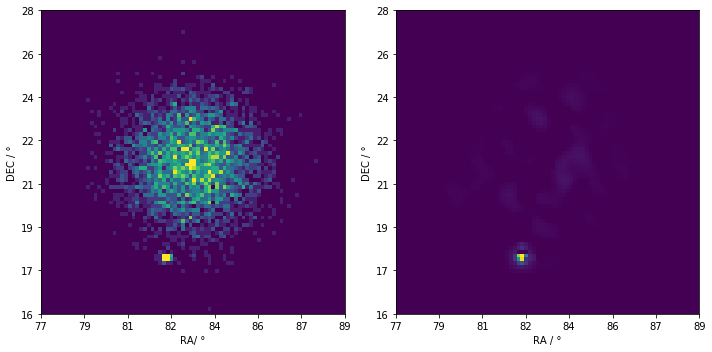

In [25]:
plot_imshow('n20_s60_trandom', 'Ra5_Dec3.6',22,21)

### Animate Imshows

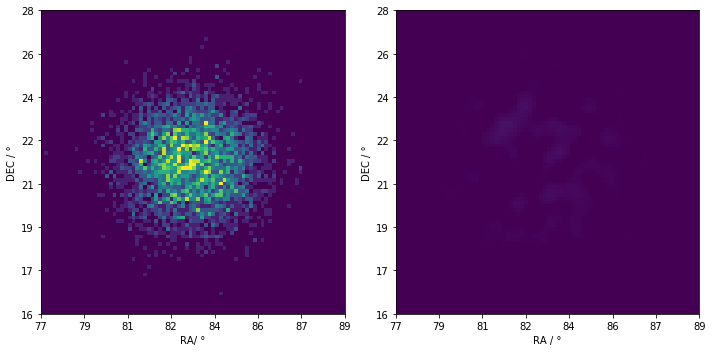

In [24]:
import matplotlib.animation as animation
import astropy.units as u
from astropy.coordinates import SkyCoord

def animate_imshows(path_to_raw_file,path_to_denoised_file,Output,number_transient):

    cube_table = Table.read(path_to_raw_file, path='data')
    denoised_table = Table.read(path_to_denoised_file, path='data')
    crab_coord = SkyCoord('05 34 31.97 +22 00 52.1', unit=(u.hourangle, u.deg))
    fov = cube.meta['fov'] 
    
    Cube = cube_table['cube'][number_transient]
    Den = denoised_table['cube_smoothed'][number_transient]


    fig, (ax1,ax2) = plt.subplots(1,2, sharex=True,figsize=(10,5))

    vmax = Unden.max()
    RA_min = crab_coord.ra.deg - fov / 2
    RA_max = crab_coord.ra.deg + fov / 2
    DEC_min = crab_coord.dec.deg - fov / 2
    DEC_max = crab_coord.dec.deg + fov / 2
    plt.setp((ax1,ax2), xticks=np.linspace(0,80,8), xticklabels=np.linspace(RA_min,RA_max,8,dtype=int),
            yticks = np.linspace(0,80,8),yticklabels=np.linspace(DEC_min,DEC_max,8,dtype=int))

    ax1.set_xlabel('RA/ °')
    ax2.set_xlabel('RA / °')
    ax1.set_ylabel('DEC / °')
    ax2.set_ylabel('DEC / °')
    
    
    line1 =  ax1.pcolormesh(Unden[0], cmap='viridis',vmin=0, vmax=vmax/3)
    line2 = ax2.pcolormesh(Den[0], cmap='viridis',vmin=0, vmax=vmax/3)


    def update(num,Unden,Den, line1, line2):
        line1 = ax1.pcolormesh(Unden[num], cmap='viridis',vmin=0, vmax=vmax/3)
        line2 = ax2.pcolormesh(Den[num], cmap='viridis',vmin=0, vmax=vmax/3)
        return line1,line2


    ani = animation.FuncAnimation(fig, update, np.arange(0,58), fargs=[Unden,Den, line1,line2])
    fig.tight_layout()

    ani.save('%s.gif'%(Output), writer='imagemagick', fps=15)

animate_imshows('/home/jana/Schreibtisch/Projekt_Master/cta_transient_search/build/n100_s60_trandom_cube.hdf5',
                                        '/home/jana/Schreibtisch/Projekt_Master/cta_transient_search/build/n100_s60_trandom_denoised.hdf5',
                                        'Transient_20',20)


## e.) Evaluate Position 

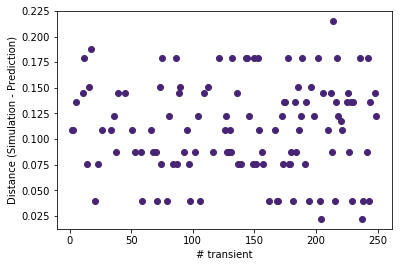

In [28]:
def plot_distances(n, thresholdname):
    ## Simulated transient (=cube without background) 
    trans = Table.read('/home/jana/Schreibtisch/Projekt_Master/cta_transient_search/build/n{}_s60_trandom_trans.hdf5'.format(n), path='data')
    True_pos = trans['position']

    ## Alert Table 
    alert = Table.read('/home/jana/Schreibtisch/Projekt_Master/cta_transient_search/build/n{}_s60_trandom{}_alert.hdf5'.format(n, thresholdname), path='data')
    Pred_pos = alert['pred_position'] 

    distances = np.zeros(len(Pred_pos))
    Ras = np.zeros(len(Pred_pos))
    Decs = np.zeros(len(Pred_pos))
    Rasim = np.zeros(len(True_pos))
    Decsim = np.zeros(len(True_pos))

    counter = 1 
    for prediction,true in zip(Pred_pos,True_pos):
        Ra_diff = true[0]-prediction[0]
        Dec_diff = true[1] - prediction[1]
        distance = np.sqrt(Ra_diff**2+Dec_diff**2)
        plt.plot(counter,distance,'o',color=viridis10)
        counter +=1
        distances[counter-2] = distance
        Ras[counter-2] = prediction[0]
        Decs[counter-2] = prediction[1]
        Rasim[counter-2] = true[0]
        Decsim[counter-2] = true[1]

    plt.xlabel('# transient')
    plt.ylabel('Distance (Simulation - Prediction)')
    plt.savefig('Results_pdf/N_{}{}_Dist.pdf'.format(n,thresholdname))
    #plt.savefig('Results_jpeg/N_{}{}_Dist.jpeg'.format(n,thresholdname))
    plt.show() ; plt.clf() 
    
plot_distances(250,'')

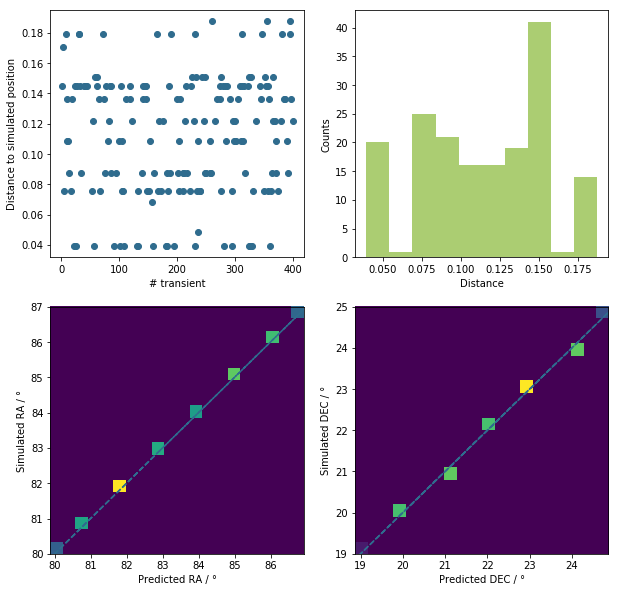

In [29]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def Plot_hists(n,alertpath):
## Simulated transient (=cube without background) 
    trans = Table.read('/home/jana/Schreibtisch/Projekt_Master/cta_transient_search/build/n{}_s60_trandom_trans.hdf5'.format(n), path='data')
    True_pos = trans['position']

    ## Alert Table 
    alert = Table.read('/home/jana/Schreibtisch/Projekt_Master/cta_transient_search/build/n{}_s60_trandom{}_alert.hdf5'.format(n,alertpath), path='data')
    Pred_pos = alert['pred_position'] 

    distances = np.zeros(len(Pred_pos))
    Ras = np.zeros(len(Pred_pos))
    Decs = np.zeros(len(Pred_pos))
    Rasim = np.zeros(len(True_pos))
    Decsim = np.zeros(len(True_pos))
    counter = 1 

    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,10))
    for prediction,true in zip(Pred_pos,True_pos):
        Ra_diff = true[0]-prediction[0]
        Dec_diff = true[1] - prediction[1]
        distance = np.sqrt(Ra_diff**2+Dec_diff**2)
        ax1.plot(counter,distance,'o',color=viridis7)
        counter +=1
        distances[counter-2] = distance
        Ras[counter-2] = prediction[0]
        Decs[counter-2] = prediction[1]
        Rasim[counter-2] = true[0]
        Decsim[counter-2] = true[1]
    ax1.set_xlabel('# transient') ; ax1.set_ylabel('Distance to simulated position')
    #########################################################
    ax2.hist(distances[np.logical_not(np.isnan(distances))],alpha=0.6, color='#73ac14')
    ax2.set_xlabel('Distance') ; ax2.set_ylabel('Counts')
    #############################################################
    im3 = ax3.hist2d(Ras[np.logical_not(np.isnan(Ras))],Rasim[np.logical_not(np.isnan(Ras))],
             bins=[20,20],cmap = 'viridis')
    ax3.plot(Ras[np.logical_not(np.isnan(Ras))],Ras[np.logical_not(np.isnan(Ras))],'--', color=viridis7)
    ax3.set_xlabel('Predicted RA / °')
    ax3.set_ylabel('Simulated RA / °')
    #############################################################
    im4 = ax4.hist2d(Decs[np.logical_not(np.isnan(Decs))],Decsim[np.logical_not(np.isnan(Decs))],
             bins=[20,20],cmap = 'viridis')
    ax4.plot(Decs[np.logical_not(np.isnan(Decs))],Decs[np.logical_not(np.isnan(Decs))],'--', color=viridis7)
    ax4.set_xlabel('Predicted DEC / °')
    ax4.set_ylabel('Simulated DEC / °')
    plt.savefig('Results_pdf/N{}{}_All.pdf'.format(n,alertpath))
    #plt.savefig('Results_jpeg/N{}{}_All.jpeg'.format(n,alertpath))
    #plt.show()
    
Plot_hists(400,'')

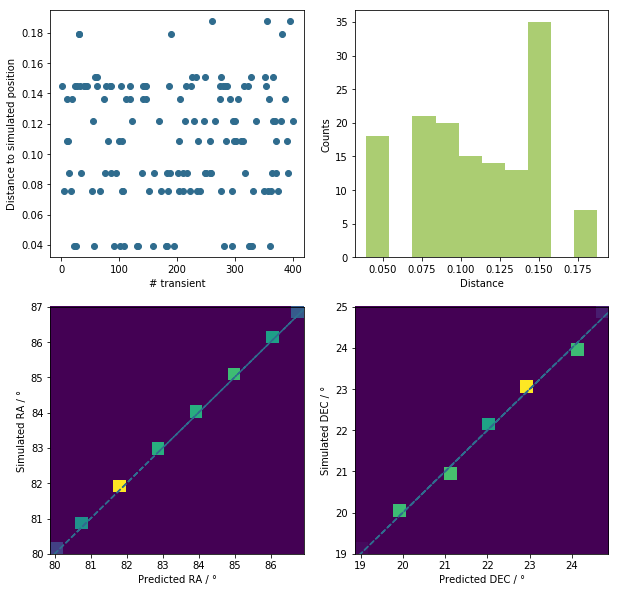

In [30]:
Plot_hists(400,'_thr14')

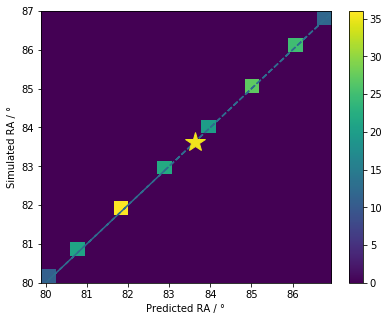

In [32]:
def Plot_RA_2D(n,alertpath):
## Simulated transient (=cube without background) 
    trans = Table.read('/home/jana/Schreibtisch/Projekt_Master/cta_transient_search/build/n{}_s60_trandom_trans.hdf5'.format(n), path='data')
    True_pos = trans['position']

    ## Alert Table 
    alert = Table.read('/home/jana/Schreibtisch/Projekt_Master/cta_transient_search/build/n{}_s60_trandom{}_alert.hdf5'.format(n,alertpath), path='data')
    Pred_pos = alert['pred_position'] 

    Ras = np.zeros(len(Pred_pos))
    Rasim = np.zeros(len(True_pos))
    distances = np.zeros(len(Pred_pos))
    counter = 1 

    for prediction,true in zip(Pred_pos,True_pos):
        Ra_diff = true[0]-prediction[0]
        counter +=1
        Ras[counter-2] = prediction[0]
        Rasim[counter-2] = true[0]
        
    #############################################################
    plt.figure(figsize=(6.5,5))
    Ra = np.ones(len(Ras[np.logical_not(np.isnan(Ras))]))*True_pos[0][0]
    plt.hist2d(Ras[np.logical_not(np.isnan(Ras))],Rasim[np.logical_not(np.isnan(Ras))],
              bins=[20,20],cmap = 'viridis')
    plt.plot(Ras[np.logical_not(np.isnan(Ras))],Ras[np.logical_not(np.isnan(Ras))],'--', color=viridis7)
    plt.plot(83.63,83.63,'*',ms=20 ,color=viridis0)
    plt.colorbar()
    plt.xlabel('Predicted RA / °')
    plt.ylabel('Simulated RA / °')
    plt.savefig('Results_pdf/2D_RA_N{}{}.pdf'.format(n,alertpath))
    #plt.savefig('Results_jpeg/2D_RA_N{}{}.jpeg'.format(n,alertpath))
    plt.show()
    
Plot_RA_2D(400,'')

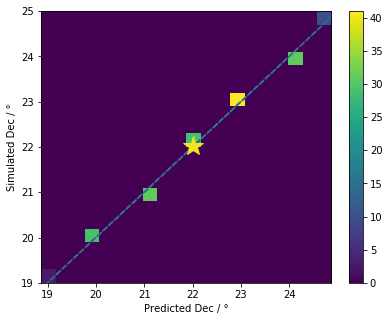

In [34]:
def Plot_DEC_2D(n,alertpath):
## Simulated transient (=cube without background) 
    trans = Table.read('/home/jana/Schreibtisch/Projekt_Master/cta_transient_search/build/n{}_s60_trandom_trans.hdf5'.format(n), path='data')
    True_pos = trans['position']

    ## Alert Table 
    alert = Table.read('/home/jana/Schreibtisch/Projekt_Master/cta_transient_search/build/n{}_s60_trandom{}_alert.hdf5'.format(n,alertpath), path='data')
    Pred_pos = alert['pred_position'] 

    Decs = np.zeros(len(Pred_pos))
    Decsim = np.zeros(len(True_pos))
    counter = 1 

    for prediction,true in zip(Pred_pos,True_pos):
        Dec_diff = true[1] - prediction[1]
        counter +=1
        Decs[counter-2] = prediction[1]
        Decsim[counter-2] = true[1]
    #############################################################
    plt.figure(figsize=(6.5,5))
    plt.hist2d(Decs[np.logical_not(np.isnan(Decs))],Decsim[np.logical_not(np.isnan(Decs))],
              bins=[20,20],cmap = 'viridis')
    plt.plot(Decs[np.logical_not(np.isnan(Decs))],Decs[np.logical_not(np.isnan(Decs))],'--', color=viridis7)
    plt.plot(22.0145,22.0145,'*',ms=20 ,color=viridis0)
    plt.colorbar()
    plt.xlabel('Predicted Dec / °')
    plt.ylabel('Simulated Dec / °')
    #plt.savefig('Results_pdf/2D_DEC_N{}{}.pdf'.format(n,alertpath))
    plt.savefig('Results_jpeg/2D_DEC_N{}{}.jpeg'.format(n,alertpath))
    plt.show()
    
Plot_DEC_2D(400,'')

# 2. Threshold studies
- Where to cut distances
- Where to cut threshold to detect more transients
- How to minimize the False trigger rate


------> See branch *Different_threshold_studies* with **Show_thresholds.py** for plots 

In [35]:
import astropy.units as u
from astropy.coordinates import SkyCoord
crab_coord = SkyCoord('05 34 31.97 +22 00 52.1', unit=(u.hourangle, u.deg))
crab_coord

<SkyCoord (ICRS): (ra, dec) in deg
    ( 83.63320833,  22.01447222)>

## a.) Direction 

- Point Spread function
- True detections around Steady Source 
- Optimal distance 

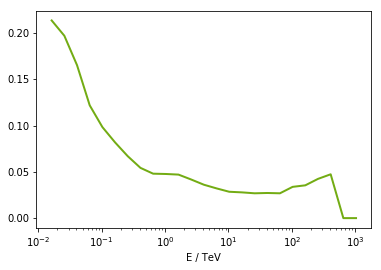

In [37]:
from collections import OrderedDict
cta_perf_fits = fits.open('../caldb/data/cta/prod3b/bcf/South_z20_average_100s/irf_file.fits')
data_ang_res = cta_perf_fits['POINT SPREAD FUNCTION']
psf_cta_south = OrderedDict({
                                    "E_TeV": (data_ang_res.data['ENERG_LO'][0] + data_ang_res.data['ENERG_HI'][0])/2,
                                    "psf_sigma": data_ang_res.data['SIGMA_1'][0]
                                })
'''
Plot
'''
plt.plot(psf_cta_south['E_TeV'], psf_cta_south['psf_sigma'][0],color='#73ac14',alpha=1,lw=2)
plt.xlabel('E / TeV') ; plt.xscale('log')

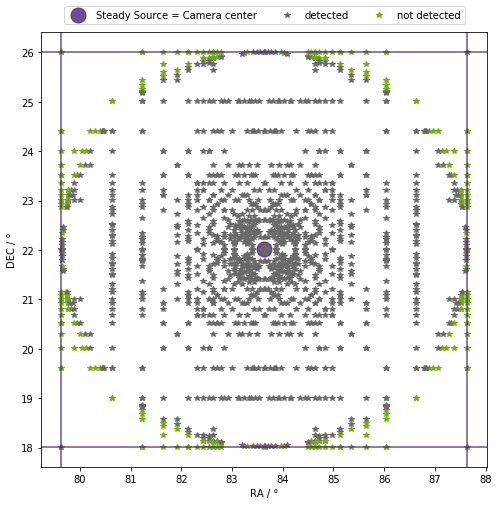

In [39]:
distances = [] 
Detection = []

def get_RA(point):
    return crab_coord.ra/u.deg - 12/point
def get_DEC(point):
    return crab_coord.dec/u.deg - 12/point

def calculate_points(Ra,Dec,detected,Copy):
    RA1 = crab_coord.ra/u.deg - 12/Ra
    DEC1 = crab_coord.dec/u.deg - 12/(Dec)
    RA2 = crab_coord.ra/u.deg + 12/Ra
    DEC2 = crab_coord.dec/u.deg + 12/(Dec)
    RA_minus = crab_coord.ra/u.deg - RA1
    DEC_minus = crab_coord.dec/u.deg - DEC1
    distance = np.sqrt(RA_minus**2 + DEC_minus**2)
    distances.append(distance)
    colo = '#73ac14'
    if detected == True:
        colo = 'dimgray'
        Detection.append(1)
        #if distance < 4.01 and distance >=4:
           # print(Ra,Dec)
    else:
        Detection.append(0)
    plt.plot(RA1,DEC1,'*',color=colo)
    plt.plot(RA1,DEC2,'*',color=colo)
    plt.plot(RA2,DEC1,'*',color=colo)
    plt.plot(RA2,DEC2,'*',color=colo)

    if(Copy):
        calculate_points(Dec,Ra,detected,False)
        Copy = False

fig = plt.figure(figsize=[8,8])
plt.plot(crab_coord.ra, crab_coord.dec,'o', color=viridis10,alpha=0.8, ms=15,label='Steady Source = Camera center')
plt.plot(crab_coord.ra/u.deg-1, crab_coord.dec/u.deg-1,'*', color='dimgray',label='detected')
plt.plot(crab_coord.ra/u.deg-4, crab_coord.dec/u.deg-4,'*', color='#73ac14',label='not detected')
calculate_points(3,3,False,True)
calculate_points(3,5,False,True)
calculate_points(3,8,False,True)
calculate_points(3,12,False,True)
calculate_points(3.3,12,True,True)
calculate_points(4,4,False,True)
calculate_points(4,5,True,True)
calculate_points(4,6,True,True)
calculate_points(4,9,True,True)
calculate_points(4,12,True,True)
calculate_points(5,3,False,True)
calculate_points(5,4,True,True)
calculate_points(5,5,True,True)
calculate_points(5,3.5,False,True)
calculate_points(5,3.6,False,True)
calculate_points(5,3.7,False,True)
calculate_points(5,3.75,False,True)
calculate_points(5,3.8, True,True)
calculate_points(5,3.77,True,True)
calculate_points(5,3.78,True,True)
calculate_points(3.2,10,True,True)
calculate_points(3.2,12,True,True)
calculate_points(3.1,10,False,True)
calculate_points(3.1,11,False,True)
calculate_points(3.1,12,True,True)
calculate_points(6,3.2,False,True)
calculate_points(6,3.0,False,True)
calculate_points(6,3.35,False,True)
calculate_points(6,3.42,False,True)
calculate_points(6,3.5,True,True)
calculate_points(6,6,True,True)
calculate_points(7,3,False,True)
calculate_points(7,3.5,True,True)
calculate_points(7,3.4,True,True)
calculate_points(7,3.3,False,True)
calculate_points(8,3,False,True)
calculate_points(8,3.25,True,True)
calculate_points(8,3.3,True,True)
calculate_points(8,3.2,False,True)
calculate_points(8,4,True,True)
calculate_points(9,3,False,True)
calculate_points(9,3.2,True,True)
calculate_points(9,9,True,True)
calculate_points(10,3,False,True)
calculate_points(10,3.15,True,True)
calculate_points(10,3.1,False,True)
calculate_points(11,3,False,True)
calculate_points(11,3.1,False,True)
calculate_points(11,3.18,True,True)
calculate_points(11,3.14,True,True)
calculate_points(12,3,False,True)
calculate_points(12,3.1,True,True)
calculate_points(12,3.09,False,True)
calculate_points(12,3.08,False,True)
calculate_points(13,3,False,True)
calculate_points(13,3.09,True,True)
calculate_points(13,3.08,False,True)
calculate_points(14,3,False,True)
calculate_points(14,3.07,False,True)
calculate_points(14,3.08,True,True)



calculate_points(5,10,True,True)
calculate_points(5,14,True,True)
calculate_points(6,8,True,True)
calculate_points(6,11,True,True)
calculate_points(6,15,True,True)
calculate_points(7,7,True,True)
calculate_points(7,12,True,True)
calculate_points(8,6,True,True)
calculate_points(8,8,True,True)
calculate_points(8,11,True,True)
calculate_points(8,13,True,True)
calculate_points(9,5,True,True)
calculate_points(9,10,True,True)
calculate_points(9,12,True,True)
calculate_points(10,4,True,True)
calculate_points(10,6,True,True)
calculate_points(10,10,True,True)
calculate_points(10,14,True,True)
calculate_points(11,4,True,True)
calculate_points(11,6,True,True)
calculate_points(11,9,True,True)
calculate_points(11,12,True,True)
calculate_points(12,5,True,True)
calculate_points(12,8,True,True)
calculate_points(12,11,True,True)
calculate_points(12,15,True,True)
calculate_points(13,5,True,True)
calculate_points(13,8,True,True)
calculate_points(13,13,True,True)
calculate_points(14,4,True,True)
calculate_points(14,8,True,True)
calculate_points(14,12,True,True)
calculate_points(15,4,True,True)
calculate_points(15,9,True,True)
calculate_points(15,15,True,True)
calculate_points(17,4,True,True)
calculate_points(17,7,True,True)
calculate_points(17,11,True,True)
calculate_points(17,20,True,True)
calculate_points(19,5,True,True)
calculate_points(19,10,True,True)
calculate_points(19,15,True,True)
calculate_points(21,8,True,True)
calculate_points(21,12,True,True)
calculate_points(21,24,True,True)
calculate_points(23,4,True,True)
calculate_points(23,8,True,True)
calculate_points(23,12,True,True)
calculate_points(23,18,True,True)
calculate_points(24,24,True,True)
calculate_points(27,3.03,True,True)
calculate_points(30,3.02,True,True)
calculate_points(36,3.01,False,True)
calculate_points(24,4,True,True)
calculate_points(24,7,True,True)
calculate_points(24,9,True,True)
calculate_points(27,7,True,True)
calculate_points(27,11,True,True)
calculate_points(27,17,True,True)
calculate_points(27,21,True,True)
calculate_points(27,40,True,True)
calculate_points(27,25,True,True)
calculate_points(30,4,True,True)
calculate_points(30,8,True,True)
calculate_points(30,11,True,True)
calculate_points(30,20,True,True)
calculate_points(30,26,True,True)
calculate_points(36,5,True,True)
calculate_points(36,9,True,True)
calculate_points(36,11,True,True)
calculate_points(36,15,True,True)
calculate_points(36,21,True,True)
calculate_points(36,27,True,True)
calculate_points(36,31,True,True)
calculate_points(40,4,True,True)
calculate_points(40,7,True,True)
calculate_points(40,12,True,True)
calculate_points(40,18,True,True)
calculate_points(40,22,True,True)
calculate_points(40,29,True,True)
calculate_points(40,35,True,True)
calculate_points(40,40,True,True)
calculate_points(45,4,True,True)
calculate_points(45,8,True,True)
calculate_points(45,13,True,True)
calculate_points(45,20,True,True)
calculate_points(50,5,True,True)
calculate_points(50,15,True,True)
calculate_points(50,25,True,True)
calculate_points(55,5,True,True)
calculate_points(55,3.01,True,True)
calculate_points(55,8,True,True)
calculate_points(55,13,True,True)
calculate_points(55,23,True,True)
calculate_points(55,35,True,True)
calculate_points(60,5,True,True)
calculate_points(60,10,True,True)
calculate_points(60,18,True,True)
calculate_points(60,24,True,True)
calculate_points(60,32,True,True)
calculate_points(60,50,True,True)
calculate_points(70,4,True,True)
calculate_points(70,8,True,True)
calculate_points(70,13,True,True)
calculate_points(70,20,True,True)
calculate_points(70,40,True,True)
calculate_points(85,3.01,True,True)
calculate_points(85,7,True,True)
calculate_points(85,14,True,True)
calculate_points(85,21,True,True)
calculate_points(85,30,True,True)
calculate_points(100,5,True,True)
calculate_points(100,12,True,True)
calculate_points(100,20,True,True)
calculate_points(100,35,True,True)
calculate_points(120,4,True,True)
calculate_points(120,10,True,True)
calculate_points(120,20,True,True)
calculate_points(120,35,True,True)
calculate_points(150,3.01,True,True)
calculate_points(150,15,True,True)
calculate_points(150,50,True,True)




calculate_points(1000,3,False,True)
calculate_points(1000,3.01,True,True)
calculate_points(1000,5,True,True)
calculate_points(1000,9,True,True)
calculate_points(1000,15,True,True)
calculate_points(1000,20,True,True)
calculate_points(1000,50,True,True)
calculate_points(1000,200,True,True)


plt.axvline(get_RA(3),color=viridis10,alpha=0.8)
plt.axvline(get_RA(-3),color=viridis10,alpha=0.8)
plt.axhline(get_DEC(3),color=viridis10,alpha=0.8)
plt.axhline(get_DEC(-3),color=viridis10,alpha=0.8)

plt.xlabel('RA / °')
plt.ylabel('DEC / °')


plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.07),
          ncol=3)


#plt.ylim(17.9,22.2)
#plt.xlim(79.6,83.6)
#plt.savefig('Results_pdf/All_posotions.pdf')  # Lims weglassen, axvlines weglassen 
#plt.savefig('Results_pdf/All_posotions_thresholds.pdf')  # Lims weglassen
#plt.savefig('Results_pdf/All_posotions_thresholds_simulated.pdf')  # Lims 16-28 & 77.6-89.6
#plt.savefig('Results_pdf/All_posotions_thresholds_threshold.pdf')  # Lims 79.6-83.9 & 17.9-22.2

plt.show()

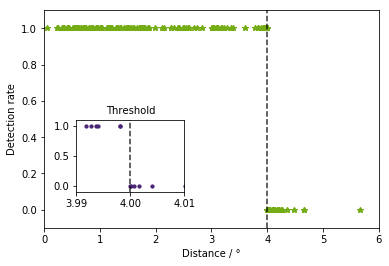

In [42]:
plt.plot(distances,Detection,'*',color='#73ac14')
plt.axis([0, 6, -0.1, 1.1])
plt.axvline(4, color='k',alpha=0.8,linestyle='--')
plt.xlabel('Distance / °')
plt.ylabel('Detection rate')
a = plt.axes([0.2,0.25,0.25,0.25])
plt.plot(distances,Detection,'.',color=viridis10, alpha=0.8)
plt.xlim(3.99,4.01)
plt.ylim(-0.1,1.1)
plt.axvline(4, color='k',alpha=0.8,linestyle='--')
plt.title('Threshold',fontsize='medium')
#plt.savefig('Results_pdf/Search_Distance_min_threshold.pdf')
plt.savefig('Results_jpeg/Search_Distance_min_threshold.jpeg')

## b.) Threshold trigger criterion 

See Show_Thresholds.py and Plots *n{}_s60_trandom_thresholds.pdf* 

## c.) Settings in analyse_cube 

- gap length to 4 
- n_bg slices to 4 
- n_wavelet to 8 

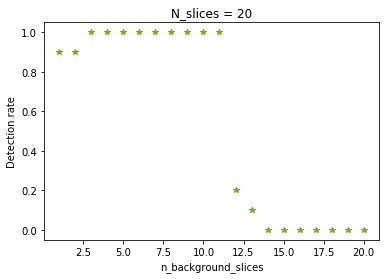

In [55]:
detected_x = np.array([3,4,5,6,7,8,9,10,11])
detected_y = np.array([1,1,1,1,1,1,1,1,1])

not_detected_x = np.array([1,2,12,13,14,15,16,17,18,19,20])
not_detected_y = np.array([9/10,9/10,2/10,1/10,0,0,0,0,0,0,0])

plt.plot(detected_x,detected_y,'*',color='#73ac14')
plt.plot(not_detected_x,not_detected_y,'*', color='#73ac14')
plt.xlabel('n_background_slices')
plt.ylabel('Detection rate')
plt.title('N_slices = 20')
plt.savefig('Results_pdf/N_background.pdf')

## d.) Crab Flux 

In [44]:
from scipy.constants import e as elem
from scipy.integrate import quad 

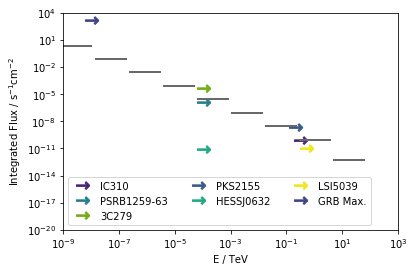

In [58]:
## Crab Nebula
E0 = 1 ; f0 = 3.8*1e-11 ; alpha = 2.21 ;Ec = 6 
plt.yscale('log')
plt.xscale('log')
plt.ylim((1e-20,1e4))
plt.xlim((1e-9,1e3))
xlin = np.logspace(-9,2,10)
for i in xlin:
    integral = quad(Plaw_Cut,i,i*10,args=(E0,f0,alpha, Ec))[0]
    plt.errorbar(i*6,integral, xerr=5.2*i,yerr=None,fmt='',color='dimgray', ecolor='dimgray', 
                 elinewidth=2, capsiz5=None,errorevery=1)
plt.xscale('log') ; plt.yscale('log')
plt.xlabel('E / TeV')
plt.ylabel('Integrated Flux / $\mathrm{s}^{-1} \mathrm{cm}^{-2}$')
    
## Single peakfluxes 
plt.scatter(0.3,6e-11, c=viridis10,marker=r'$\rightarrow$',s=200, label='IC310' )
plt.scatter(0.0001,11e-7, c=viridis6,marker=r'$\rightarrow$',s=200, label='PSRB1259-63' )
plt.scatter(0.0001,350e-7, c='#73ac14',marker=r'$\rightarrow$',s=200, label='3C279' )
plt.scatter(0.2,1.72e-9, c=viridis8,marker=r'$\rightarrow$',s=200, label='PKS2155' )
plt.scatter(0.0001,0.71e-11, c=viridis4,marker=r'$\rightarrow$',s=200, label='HESSJ0632' )
plt.scatter(0.5,8.8e-12, c=viridis0,marker=r'$\rightarrow$',s=200, label='LSI5039' )
plt.scatter(10e-9,1051, c=viridis9,marker=r'$\rightarrow$',s=200, label='GRB Max.' )
plt.legend(ncol = 3)

plt.savefig('Results_pdf/Peak_fluxes.pdf')

Text(0,0.5,'Detection rate')

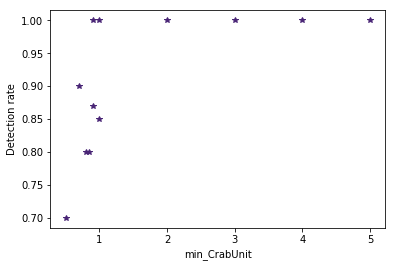

In [63]:
cu_min = np.array([5,4,3,2,1,0.5,0.7,0.8,0.9,0.85,0.9,1])
detected = np.array([1,1,1,1,1,7/10,9/10,8/10,10/10,8/10,87/100,85/100])

plt.plot(cu_min,detected,'*', color=viridis10)
plt.xlabel('min_CrabUnit')
plt.ylabel('Detection rate')

## e.) Background Studies

- TP : Transient simulated and detected
- TN : No transient simulated and not detected
- FP : No transient simulated but detected
- FN : Transient simulated put not detected 

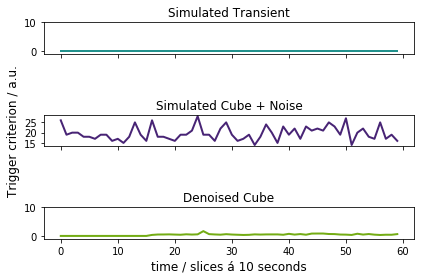

In [77]:
## Simulated cube 
cube = Table.read('/home/jana/Schreibtisch/Projekt_Master/cta_transient_search/build/n10_s60_trandom_cube.hdf5', path='data')
Cube = cube['cube'].max(axis=2).max(axis=2)
## Simulated transient (=cube without background) 
trans = Table.read('/home/jana/Schreibtisch/Projekt_Master/cta_transient_search/build/n10_s60_trandom_trans.hdf5', path='data')
##denoised cube 
den = Table.read('/home/jana/Schreibtisch/Projekt_Master/cta_transient_search/build/n10_s60_trandom_denoised.hdf5', path='data')
trans_factor = den['cube_smoothed'].max(axis=2).max(axis=2)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True)
ax2.plot(Cube[0],color=viridis10, lw=2)
ax2.set_title('Simulated Cube + Noise')

ax1.plot(np.zeros(60),color=viridis5,lw=2)
ax1.set_title('Simulated Transient')
ax1.set_ylim(-1,10)

ax3.plot(trans_factor[0],color='#73ac14',lw=2)
ax3.set_ylim(-1,10)
ax3.set_title('Denoised Cube')

ax3.set_xlabel('time / slices á 10 seconds',size='large')
ax2.set_ylabel('Trigger criterion / a.u.',size='large')

fig.tight_layout()
#plt.savefig('Results_jpeg/Signal.jpeg',bbox_inches='tight')
plt.savefig('Results_pdf/No_Signal.pdf',bbox_inches='tight')